# Undistortion

In [105]:
import numpy as np
import pyfits
import matplotlib.pyplot as plt
import skimage
from skimage.feature import blob_dog, blob_doh, blob_log, canny
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.segmentation import slic
from skimage.filters import sobel
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from skimage import measure
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick

# Forward distortion model given the distortion coefficient

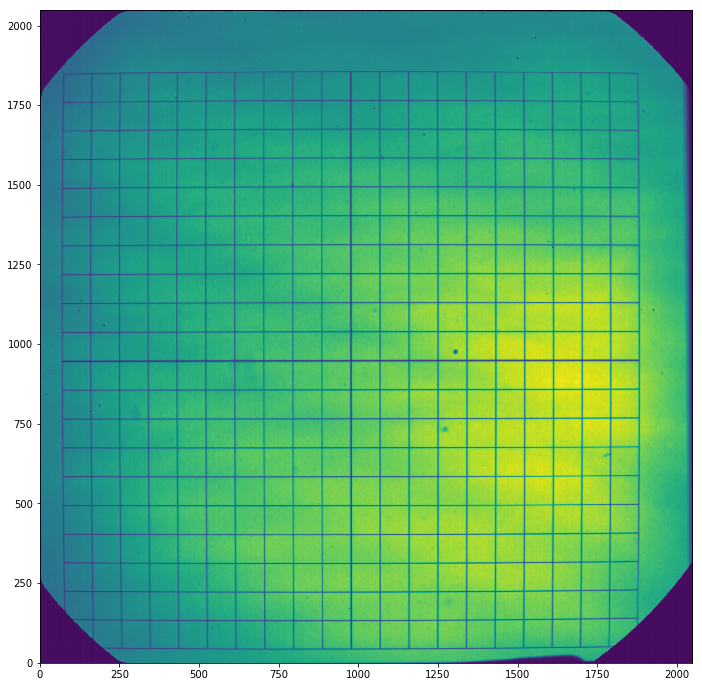

In [106]:
#path = '/home/kahil/Desktop/Solar-Orbiter/'
#path = '/home/fatima/Desktop/solar_orbiter_project/codes/targets/'
grid = pyfits.getdata('calibration_lines.fits')
#circles = pyfits.getdata('dark.fits')
#circles = circles-dark
plt.figure(figsize=(18,12))

plt.imshow(grid, origin='lower')

# Problem 1: 
## If I want to use the forward model to compute the position of the undistorted coordinates, the resultant image will be larger if the distortion is barrel and smaller if the distortion is pincushion.

# Problem 2:
## The undistorted coordinates are not integers

In [8]:
und = np.zeros((2500,2500))
und.shape

(2500, 2500)

In [9]:
x_d = np.arange(0,2048)
y_d = np.arange(0,2048)
x_c =  1023
y_c = 1023
k = 8e-09
r_d = np.sqrt((x_d-x_c)**2+(y_d-y_c)**2)
x_u = x_d + (x_d-x_c)*(k)*(r_d**2)
y_u = y_d + (y_d-y_c)*(k)*(r_d**2)

In [10]:
print x_u, y_u, len(x_u)

[ -17.12958667  -16.07940237  -15.02931618 ... 2062.07940237 2063.12958667
 2064.17986918] [ -17.12958667  -16.07940237  -15.02931618 ... 2062.07940237 2063.12958667
 2064.17986918] 2048


In [107]:
Ny, Nx = circles.shape
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
x_d = 1009#center[1]
y_d= 911#center[0]
k = 8e-09
und = np.zeros((2200,2200))

In [108]:
for y_d in range(Ny):
    for x_d in range(Nx):
        r_d = np.sqrt((x_d-x_c)**2+(y_d-y_c)**2)
        x_u = x_d + (x_d-x_c)*(k)*(r_d**2)
        y_u = y_d + (y_d-y_c)*(k)*(r_d**2)
        
        und[int(y_u)][int(x_u)] = grid[y_d][x_d] 

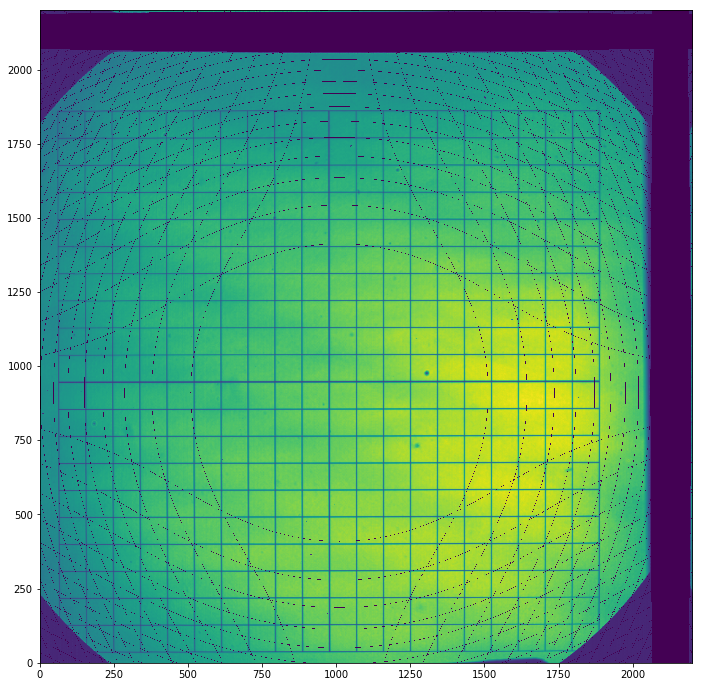

In [111]:
plt.figure(figsize=(18,12))
plt.imshow(und,origin='lower')
plt.savefig('grid_und_holes.png',dpi=300)

In [112]:
circles = pyfits.getdata('calibration_circles.fits')


In [113]:
Ny, Nx = circles.shape
i,j = np.indices([Ny,Nx])
center = np.array([(i.max()-i.min())/2.0, (j.max()-j.min())/2.0])
x_d = 1009#center[1]
y_d= 911#center[0]
k = 8e-09
und = np.zeros((2200,2200))
for y_d in range(Ny):
    for x_d in range(Nx):
        r_d = np.sqrt((x_d-x_c)**2+(y_d-y_c)**2)
        x_u = x_d + (x_d-x_c)*(k)*(r_d**2)
        y_u = y_d + (y_d-y_c)*(k)*(r_d**2)
        
        und[int(y_u)][int(x_u)] = circles[y_d][x_d] 

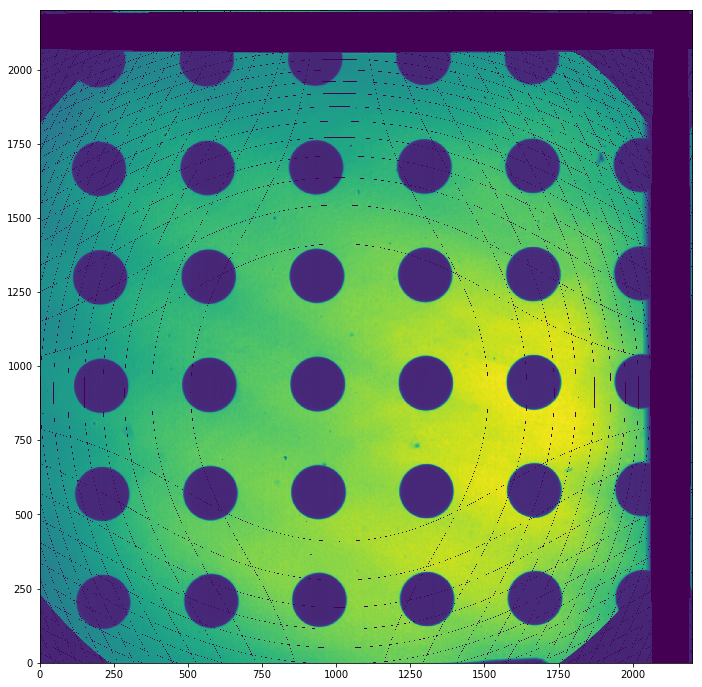

In [114]:
plt.figure(figsize=(18,12))
plt.imshow(und,origin='lower')
plt.savefig('circles_und_holes.png',dpi=300)

# Inverse distortion
## To correct an image taken with the same camera for the distortion, we start with the mapping the pixel position in the output corrected image to that in the distorted image. For that, we need to invert the forward model, which will give the distorted coordinates.
## I will follow the equation given in Wang et al.

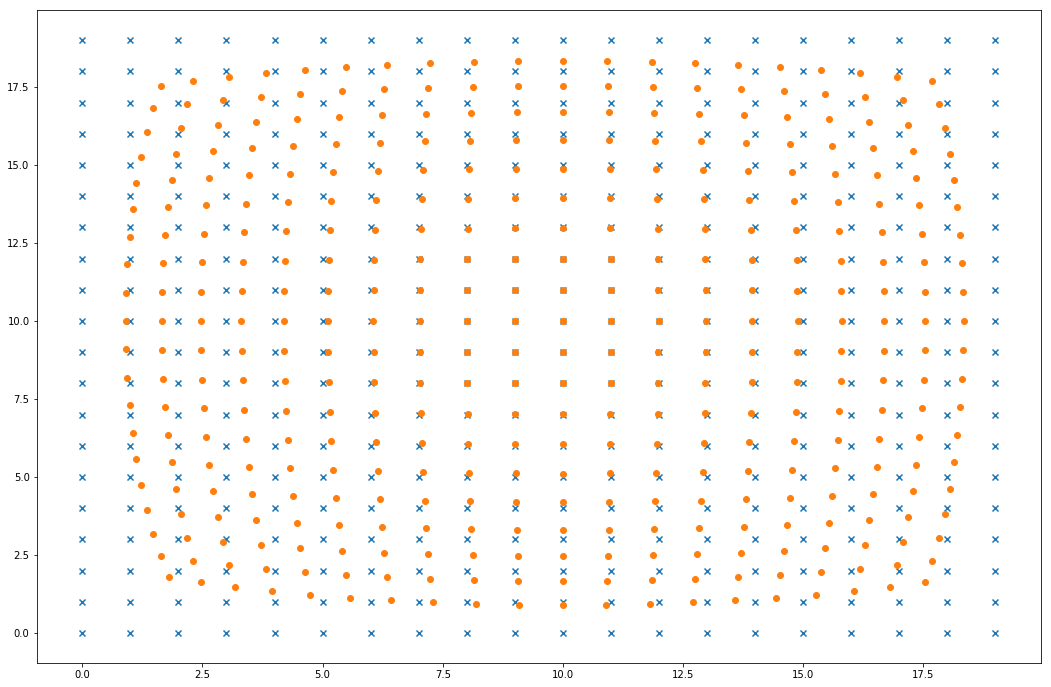

In [47]:

x_c,y_c =  10,10
k = -9e-04
P_1 = 0
P_2 = 0

def For(x_c,y_c,x_d,y_d,k, P_1,P_2):
  r_d = np.sqrt((x_d-x_c)**2+(y_d-y_c)**2)
  x_u = x_d + (x_d-x_c)*(k*r_d**2) + (P_1*(r_d**2+2*(x_d-x_c)**2)+2*P_2*(x_d-x_c)*(y_d-y_c))
  y_u = y_d + (y_d-y_c)*(k*r_d**2) + 2*P_1*(x_d-x_c)*(y_d-y_c) + P_2*(r_d**2+2*(y_d-y_c)**2)
  return x_u, y_u

def Inv(x_c,y_c,x_u,y_u,k):
  r_u = np.sqrt((x_u-x_c)**2+(y_u-y_c)**2)
  x_d = x_c + (x_u-x_c)*(1+k*r_u**2)
  y_d = y_c + (y_u-y_c)*(1+k*r_u**2) 
  return x_d,y_d

fig = plt.figure(figsize=(18,12))
x_t = np.arange(20)
y_t = np.arange(20)
xy = np.meshgrid(x_t,y_t)
x_d,y_d = For(x_c,y_c,xy[0],xy[1],k,P_1,P_2)
plt.scatter(xy[0], xy[1],marker='x')
plt.scatter(x_d, y_d,marker='o')



## This inverse function is based on solving the forward distortion equation for $r_d$ 

In [23]:
## choose x_u, y_d from (0,2048)

def Inv3(x_c,y_c,x_u,y_u,k):
  x_u = x_u-x_c
  y_u = y_u - y_c
  r_u = np.sqrt((x_u)**2+(y_u)**2)
  delta = (1./(3*k))**3 + (r_u/(2*k))**2
  r_d = np.cbrt((r_u/2*k) + np.sqrt(delta))  + (1./(3*k))*1/(np.cbrt( r_u/(2*k) + np.sqrt(delta) ))
  M = (1./(1+k*r_d**2))
  x_d = (x_u)*M
  y_d = (y_u)*M
  x_d = x_d + x_c
  y_d = y_d+y_c
  return x_d,y_d

In [12]:
def Inv2(x_c,y_c,x_u,y_u,k):
  r_u = np.sqrt((x_u-x_c)**2+(y_u-y_c)**2) 
  x_d = x_c+(x_u-x_c)*(1-k*r_u**2)
  y_d = y_c+(y_u-y_c)*(1-k*r_u**2)
  return x_d,y_d
    


In [30]:
# based on park et al:
def Inv(x_c,y_c,x_u,y_u,k):
    x_u = x_u-x_c
    y_u = y_u - y_c
    r_u = np.sqrt((x_u)**2+(y_u**2))
    r_d = (-1+np.sqrt(1+4*k*r_u**2))/(2*k*r_u)
    M = (-1+np.sqrt(1+4*k*r_u**2))/(2*k*r_u**2)#1./(1+k*r_d**2) #r_d/r_u#
    x_d = x_u*M
    y_d = y_u*M
    x_d = x_d + x_c
    y_d = y_d+y_c
    return x_d,y_d

In [31]:
print Inv(2030,500,1009,911,k)
print Inv2(2030,500,1009,911,k)
print Inv3(2030,500,1009,911,k)

(1018.7071570967131, 907.0924176623417)
(1018.8944048159999, 907.017041744)
(1574.4567876167557, 683.3773362287104)


In [78]:
Inv(1009,911,0,0,k)

(14.491659366930207, 13.08414438381908)

# Bi-linear interpolation of the distorted image given an inversion function

In [83]:
x = y = np.arange(2048)
x_c =1009
y_c = 911
k=8e-09
output_inv = np.zeros((2048,2048))
Nx = Ny=2048

In [84]:
## bilinear interpolation
from scipy import interpolate

distorted = pyfits.getdata('calibration_circles.fits')
F= interpolate.interp2d(y,x,distorted, kind='linear')


In [43]:
print F(105.5,105.5)
print distorted[105][105]

[3049472.]
3073024


In [85]:
## mapping
for y_u in range(Ny):
    for x_u in range(Nx):
          x_d, y_d = Inv2(x_c,y_c,x_u,y_u,k)
          output_inv[y_u,x_u] = F(x_d, y_d)


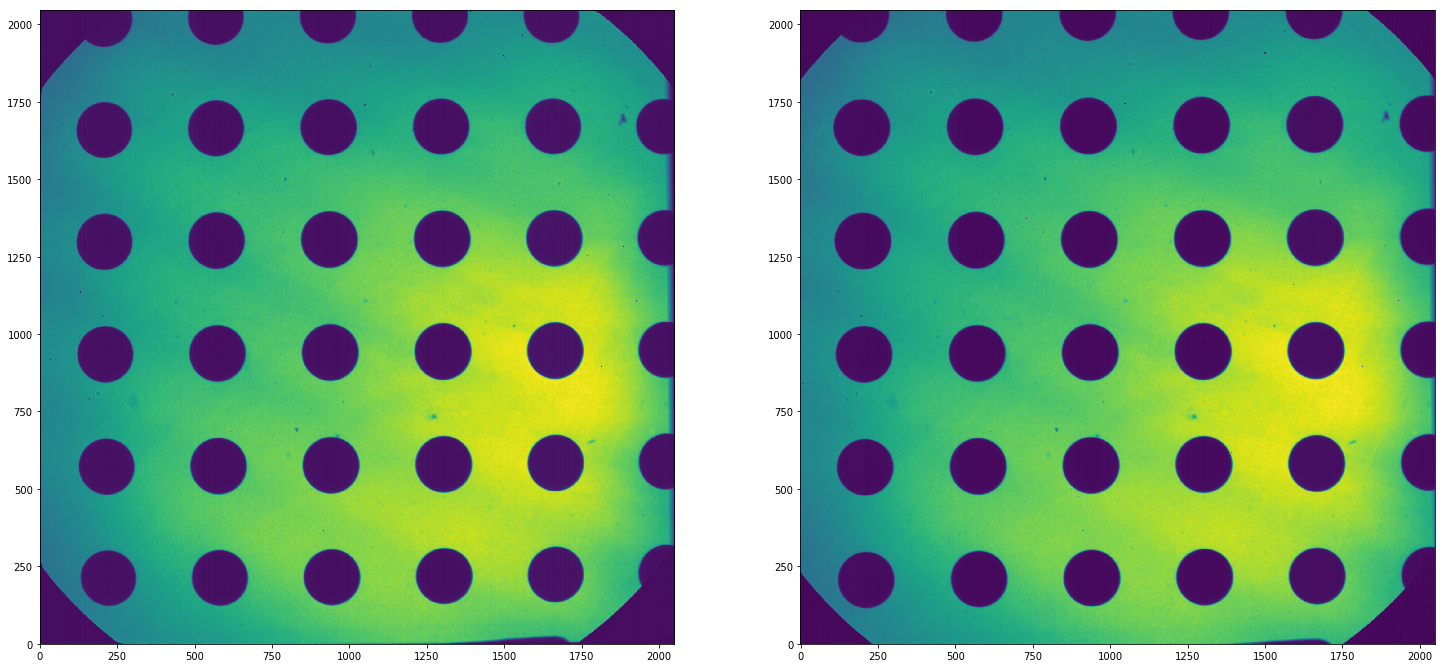

In [45]:
fig=plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(distorted,origin='lower')
ax2.imshow(output_inv,origin='lower')

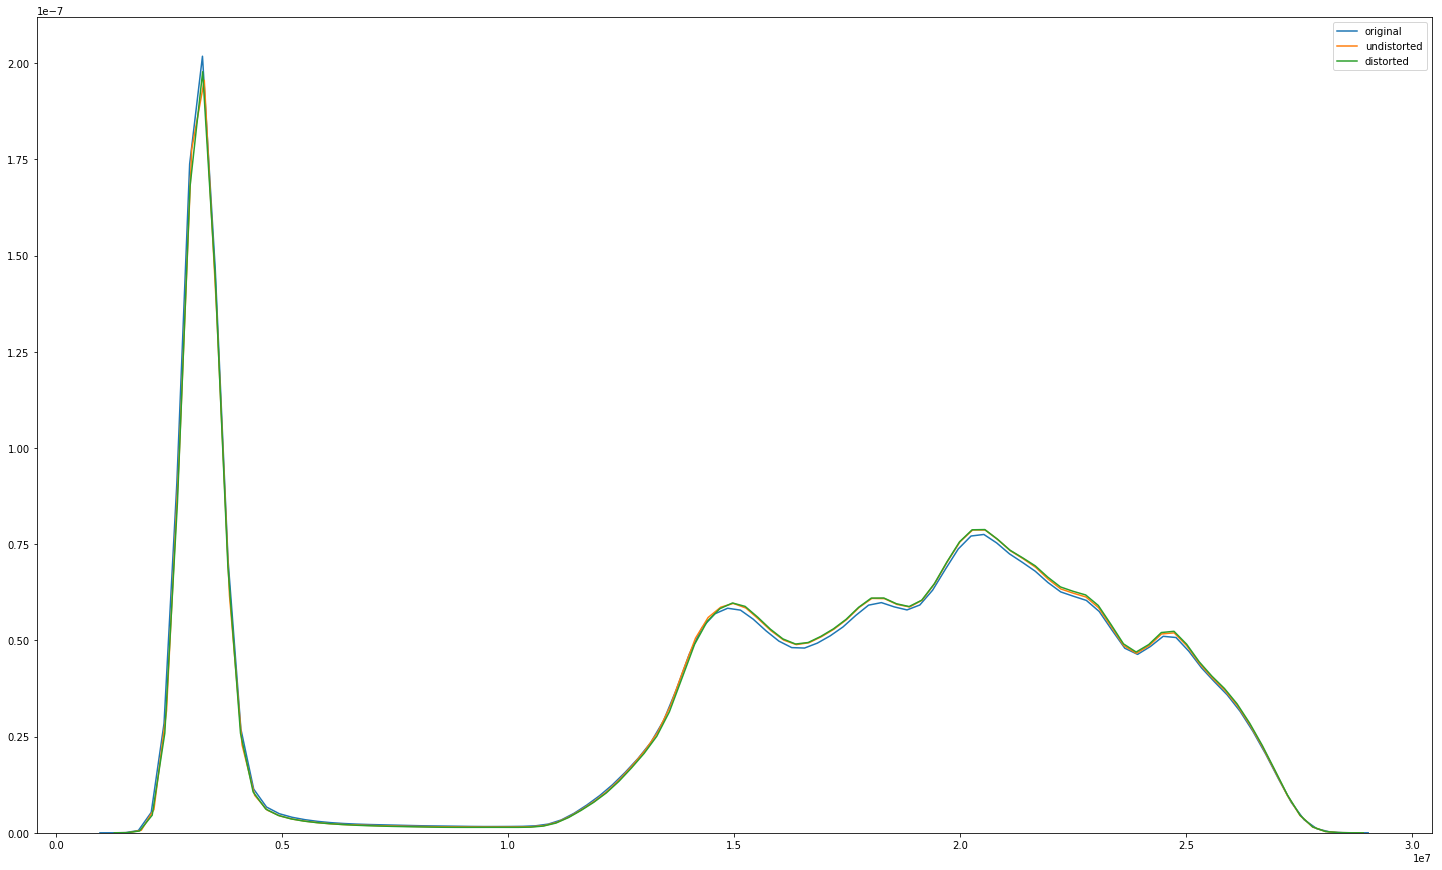

In [93]:
import seaborn as sns
distorted_t = np.ravel(distorted)
output_inv_t = np.ravel(output_inv)
output_it_t = np.ravel(output_it)
fig=plt.figure(figsize=(25,15))
sns.distplot(distorted_t,hist=False,kde=True,label='original')
sns.distplot(output_inv_t,hist=False,kde=True,label='undistorted')
sns.distplot(output_it_t,hist=False,kde=True,label='distorted')


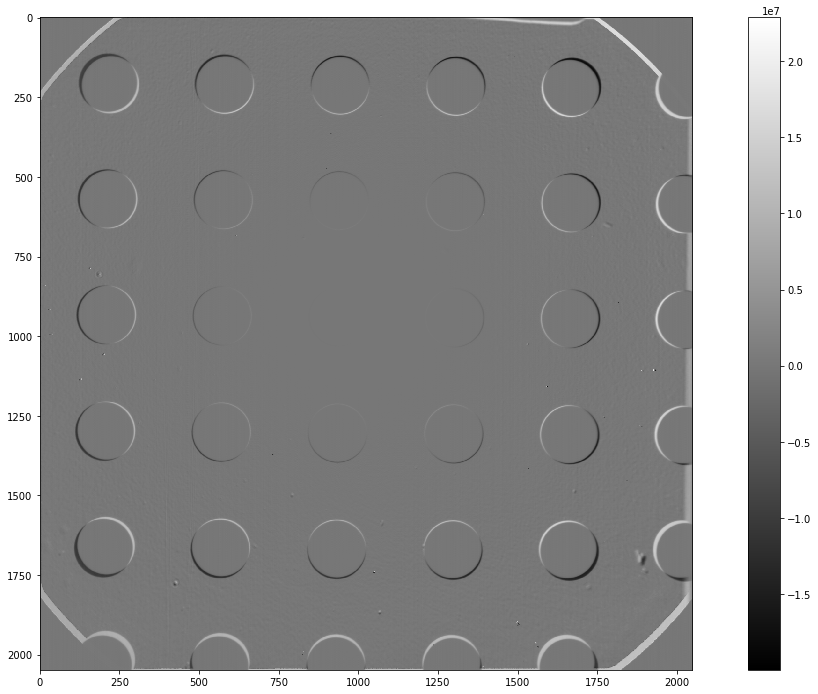

In [115]:
fig = plt.figure(figsize=(20,12))
plt.imshow(output_inv-distorted,cmap='gray')
plt.colorbar()

# undistorting the grid image

In [116]:
grid = pyfits.getdata('calibration_lines.fits')


In [117]:
x = y = np.arange(2048)
x_c =1009
y_c = 911
k=8e-09
output_inv_grid = np.zeros((2048,2048))
Nx = Ny=2048

In [118]:
F= interpolate.interp2d(y,x,grid, kind='linear')


In [119]:
## mapping
for y_u in range(Ny):
    for x_u in range(Nx):
          x_d, y_d = Inv2(x_c,y_c,x_u,y_u,k)
          output_inv_grid[y_u,x_u] = F(x_d, y_d)


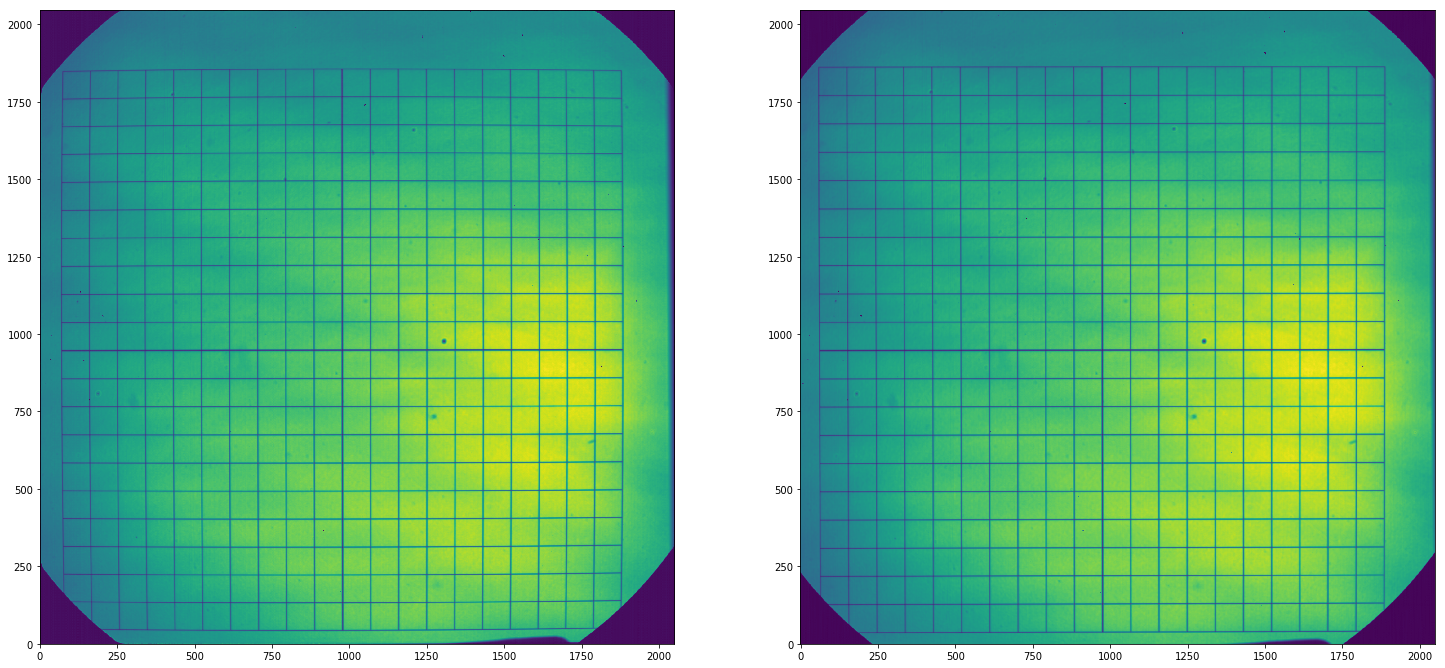

In [120]:
fig=plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(grid,origin='lower')
ax2.imshow(output_inv_grid,origin='lower')

In [121]:
hdu = pyfits.PrimaryHDU(output_inv_grid)
hdu.writeto('grid_und_inv.fits')

# Second method is to do it iteratively
## For every undistorted integer coordinates, we estimate the corresponding distorted position and iterate over them to find (using the forward model and knowing k) the closest coordinates to the understorted point in game. 

In [1]:
x = y = np.arange(2048)
x_c =1009
y_c = 911
k=8e-09
output_it = np.zeros((2048,2048))


NameError: name 'np' is not defined

In [47]:
from scipy import interpolate

distorted = pyfits.getdata('calibration_circles.fits')
F= interpolate.interp2d(y,x,distorted, kind='linear')


In [48]:
## minimize function
from scipy.optimize import minimize
def Minimize(params,x_u,y_u):
 
 x_d = params[0]; y_d = params[1]
 x_c =1009
 y_c = 911
 k=8e-09         
 r_u = np.sqrt((x_u-x_c)**2 + (y_u-y_c)**2)
 X_u = x_d + (x_d - x_c )*(k*((x_d-x_c)**2 + (x_d-y_c)**2))
 Y_u = y_d + (y_d - y_c)*(k*((y_d-x_c)**2 + (y_d-y_c)**2))
 R_u = np.sqrt((X_u-x_c)**2 + (Y_u-y_c)**2)

 return (R_u - r_u)**2



In [49]:
for x_u in range(2048):
    for y_u in range(2048):
         p0 = np.array([x_u + 0.0001, y_u+0.0001])    
         mini = minimize(Minimize,p0,args=(x_u,y_u))
         popt = mini.x
         output_it[y_u][x_u] = F(popt[0],popt[1])


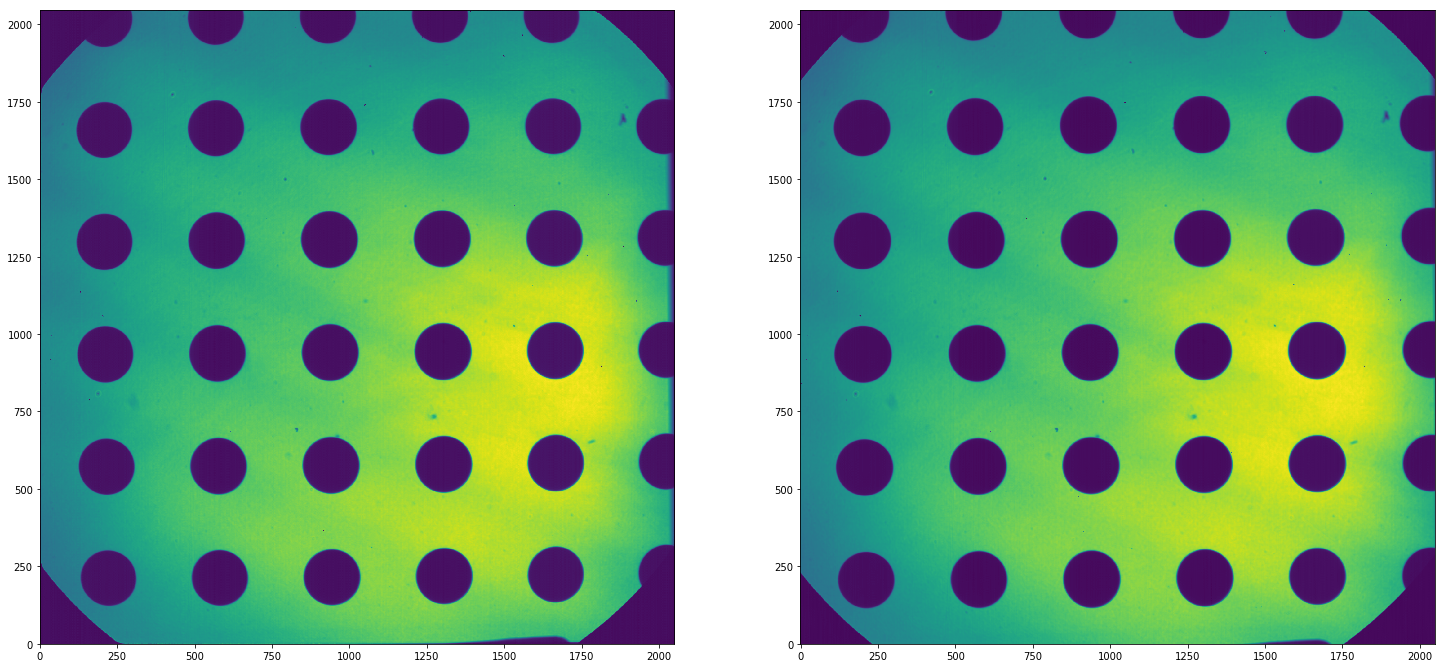

In [50]:
fig=plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(distorted,origin='lower')
ax2.imshow(output_it,origin='lower')